In [17]:
import os
import glob
import numpy as np
import pandas as pd
import math
import random
from typing import List, Dict
import matplotlib.pyplot as plt
from collections import namedtuple
from PSSimPy.simulator import ABMSim
from PSSimPy import Bank, Account
from PSSimPy.credit_facilities import SimpleCollateralized, AbstractCreditFacility
from PSSimPy.utils import add_minutes_to_time, minutes_between

from MDP import MechMDPSearch, OriMDPSearch, MDPStateExt, MDPState

# Classes

## Custom Credit Facility
Credit facility has the ability to provide credit through three means:
1. Accepting traditional collateral
2. Accepting incoming transactions as collateral
3. Providing unsecured credit

In [2]:
class CollateralizedCreditFacility(AbstractCreditFacility):
    def __init__(self, collateralized_transactions=None, gamma=0.6, phi=0.5, chi=0.75):
        AbstractCreditFacility.__init__(self)
        self.collateralized_transactions = collateralized_transactions if collateralized_transactions is not None else {}
        self.gamma = gamma  # traditional borrowing cost
        self.phi = phi      # pledged-collateral borrowing cost
        self.chi = chi      # unsecured borrowing cost
        # Track credit issued: account.id -> list of tuples (credit_type, amount)
        self.used_credit = {}
        self.history = {}

    def lend_credit(self, account, amount: float) -> None:
        """
        Issue credit to an account using one of three methods based on the following rules:
        
        1. If χ is the lowest among γ, φ, and χ, always issue unsecured credit.
        
        2. If the account has sufficient posted collateral (i.e. account.posted_collateral >= amount):
           - If φ < χ and there exists a valid incoming transaction (valid_txn) that can be used as collateral,
             issue credit via collateralized transactions (using that valid_txn).
           - Else, issue credit via posted collateral.
        
        3. If the account has insufficient posted collateral (i.e. account.posted_collateral < amount):
           - If χ < φ, issue unsecured credit.
           - Else, if there is a valid incoming transaction, issue credit via collateralized transactions.
           - Otherwise, do not provide credit.
        
        The type of credit issued is recorded in self.used_credit for later cost calculations.
        """
        # Rule 1: If unsecured borrowing cost is lowest, issue unsecured credit.
        if self.chi < self.gamma and self.chi < self.phi:
            self.used_credit.setdefault(account.id, []).append(('unsecured', amount))
            account.balance += amount
            return

        # Helper: find a valid incoming transaction for collateral.
        def find_valid_txn():
            lowest_valid_amt = float('inf')
            lowest_valid_amt_txn = None
            valid_txns = {txn for txn in account.txn_in if txn.status_code == 0 and 
                          txn not in self.collateralized_transactions.get(account.id, set())}
            for txn in valid_txns:
                if txn.amount >= amount and txn.amount < lowest_valid_amt:
                    lowest_valid_amt = txn.amount
                    lowest_valid_amt_txn = txn
            return lowest_valid_amt_txn

        # Check if account has sufficient posted collateral.
        if account.posted_collateral >= amount:
            # Rule 2: Sufficient posted collateral.
            if self.phi < self.chi:
                # Try to use a valid incoming transaction as collateral.
                valid_txn = find_valid_txn()
                if valid_txn is not None:
                    self.collateralized_transactions.setdefault(account.id, set()).add(valid_txn)
                    self.used_credit.setdefault(account.id, []).append(('collateralized_txn', amount))
                    account.balance += amount
                    return
            # Fallback: issue credit using posted collateral.
            self.used_credit.setdefault(account.id, []).append(('collateralized_posted', amount))
            account.balance += amount
            account.posted_collateral -= amount
            return
        else:
            # Rule 3: Insufficient posted collateral.
            if self.chi < self.phi:
                # Unsecured credit is cheaper.
                self.used_credit.setdefault(account.id, []).append(('unsecured', amount))
                account.balance += amount
                return
            else:
                # Try to use incoming transaction as collateral.
                valid_txn = find_valid_txn()
                if valid_txn is not None:
                    self.collateralized_transactions.setdefault(account.id, set()).add(valid_txn)
                    self.used_credit.setdefault(account.id, []).append(('collateralized_txn', amount))
                    account.balance += amount
                    return
                else:
                    # No option available: do not issue credit.
                    return

    def collect_all_repayment(self, day: int, accounts: List[Account]) -> None:
        """
        Collect repayments from all accounts.
        """
        for account in accounts:
            self.history.setdefault(account.id, []).append(
                (day, self.get_total_credit(account), self.get_total_fee(account))
            )
            self.collect_repayment(account)

    def calculate_fee(self, credit_amount, credit_type) -> float:
        """
        Calculate the fee for a given credit amount based on its type.
        
        - For 'collateralized_posted', fee = gamma * credit_amount.
        - For 'collateralized_txn', fee = phi * credit_amount.
        - For 'unsecured', fee = chi * credit_amount.
        """
        if credit_type == 'collateralized_posted':
            return self.gamma * credit_amount
        elif credit_type == 'collateralized_txn':
            return self.phi * credit_amount
        elif credit_type == 'unsecured':
            return self.chi * credit_amount
        else:
            return 0.0


    def collect_repayment(self, account) -> None:
        # Not implemented for now.
        pass

    def get_total_credit(self, account: Account) -> float:
        """
        Obtain the total amount of credit issued to an account.
        """
        return sum([amt for (ctype, amt) in self.used_credit.get(account.id, [])])

    def get_total_fee(self, account: Account) -> float:
        """
        Obtain the total fee amount for an account based on the types of credit issued.
        """
        total_fee = 0.0
        for credit_type, amount in self.used_credit.get(account.id, []):
            total_fee += self.calculate_fee(credit_amount=amount, credit_type=credit_type)
        return total_fee

    
    def get_total_credit_and_fee(self, account: Account) -> float:
        """
        Obtain the total credit and fee for an account.
        """
        return self.get_total_credit(account) + self.get_total_fee(account)


## Bank Strategy

In [3]:
mdp = MechMDPSearch(n_players=10, n_periods=10, p_t=1, delta=0.1, delta_prime=0.9, gamma=0.15, phi=0.25, chi=0.35, seed=1000)

In [4]:
class MechStrategicBank(Bank):

    def __init__(self, name, strategy_type='MechStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)
        self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
        self.mdp_previous_action = 0
        self.n_periods = 10
    
    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        if len(txns_to_settle) == 0:
            return set()
        else:
            # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
            txn = txns_to_settle.copy().pop()
            bank_account = txn.sender_account

        # calculate amount of obligations that arrived in this period
        arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
        # calculate the amount of claims that arrived in this current period
        observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

        if current_time == "08:00":
            partial_obs = {
                "inbound_payments": 0,
                "arrived_obligations": arrived_obligations,
                "observed_claims": observed_claims,
                "observed_expected": 0.75  # not used when ζ = 0
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
        else:
            # calculate actual inbound payments from previous period
            previous_time = add_minutes_to_time(current_time, -15)
            df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
            filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                    (df_processed_txns['settlement_time'] == previous_time)]
            inbound_payments = filtered_df['amount'].sum()

            partial_obs = {
                "inbound_payments": inbound_payments,
                "arrived_obligations": arrived_obligations,
                "observed_claims": observed_claims,
                "observed_expected": 0.75  # not used when ζ = 0
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

        _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
        self.n_periods -= 1
        self.mdp_previous_action = best_act

        if best_act == 1:
            return txns_to_settle
        else:
            return set()

In [5]:
class RandomBank(Bank):
    def __init__(self, name, strategy_type='OriStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)

    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        r = random.randint(0, 1)
        if r == 1:
            return txns_to_settle
        else:
            return set()

# Helper Functions

In [6]:
def calculate_delay_cost(sim_name, account: str, delta: float, delta_prime: float):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]
    
    # Initialize total delay cost
    total_delay_cost = 0
    
    # Calculate delay cost for each transaction
    for _, row in relevant_txns.iterrows():
        # Extract submission_time and time as datetime objects
        submission_time = pd.to_datetime(row['submission_time'])
        txn_time = pd.to_datetime(row['time'])
        
        # Calculate the delay in minutes (convert Timedelta to minutes)
        delay_minutes = (submission_time - txn_time).total_seconds() / 60
        
        # Calculate the delay cost
        delay_cost = (delay_minutes / 15) * (delta + delta_prime)
        
        # Accumulate the delay cost
        total_delay_cost += delay_cost
    
    return total_delay_cost

In [7]:
def calculate_borrowing_cost(sim_name, account: str):
    df_credit_facility = pd.read_csv(f'{sim_name}-credit_facility.csv')
    
    # Filter for the given account
    relevant_credit = df_credit_facility[df_credit_facility['account'] == account]

    # Initialize total borrowing cost
    total_borrowing_cost = 0

    # Calculate borrowing cost at each period
    for _, row in relevant_credit.iterrows():
        borrowing_cost = row['total_fee']
        total_borrowing_cost += borrowing_cost
    
    return total_borrowing_cost

In [24]:
def calculate_average_payment_delay(sim_name, account: str):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]

    txn_delays = []
    for _, row in relevant_txns.iterrows():
        arrival_time = row['time']
        submission_time = row['submission_time']
        delay = minutes_between(arrival_time, submission_time)/15 # normalized to periods
        txn_delays.append(delay)

    return float(np.mean(txn_delays))

In [8]:
def visualize_single_cost_distribution(total_costs: list, label="Scenario", title='Total Cost Distribution'):
    # Convert to numpy array
    costs = np.array(total_costs)

    # Compute summary statistics
    mean_cost = np.mean(costs)
    median_cost = np.median(costs)
    std_cost = np.std(costs)

    # Print summary statistics
    print(f"{label}:")
    print("Mean total cost:", mean_cost)
    print("Median total cost:", median_cost)
    print("Standard Deviation:", std_cost)
    print("")

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(costs, bins='auto', density=True, alpha=0.6, color='steelblue', edgecolor='black', label=label)

    # Overlay the mean and median as vertical lines
    plt.axvline(mean_cost, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_cost:.2f}')
    plt.axvline(median_cost, color='navy', linestyle='dotted', linewidth=2, label=f'Median: {median_cost:.2f}')

    # Labeling
    plt.title(title)
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    plt.show()

# Simulation

In [13]:
def simulate_mech_game(p_t: float, delta: float, gamma: float, delta_prime: float, phi: float, chi: float, seed: int, focal_account='acc3'):
    mdp = MechMDPSearch(
        n_players=3,
        n_periods=10,
        p_t=p_t,
        delta=delta,
        delta_prime=delta_prime,
        gamma=gamma,
        phi=phi,
        chi=chi,
        seed=seed
    )

    # redefine strategic bank
    # Set up strategic bank agent
    class MechStrategicBank(Bank):
        def __init__(self, name, strategy_type='MechStrategic', **kwargs):
            super().__init__(name, strategy_type, **kwargs)
            self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
            self.mdp_previous_action = 0
            self.n_periods = 10
        
        # overwrite strategy
        def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
            if len(txns_to_settle) == 0:
                return set()
            else:
                # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
                txn = txns_to_settle.copy().pop()
                bank_account = txn.sender_account

            # calculate amount of obligations that arrived in this period
            arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
            # calculate the amount of claims that arrived in this current period
            observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

            if current_time == "08:00":
                partial_obs = {
                    "inbound_payments": 0,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
            else:
                # calculate actual inbound payments from previous period
                previous_time = add_minutes_to_time(current_time, -15)
                df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
                filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                        (df_processed_txns['settlement_time'] == previous_time)]
                inbound_payments = filtered_df['amount'].sum()

                partial_obs = {
                    "inbound_payments": inbound_payments,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

            _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
            self.n_periods -= 1
            self.mdp_previous_action = best_act

            if best_act == 1:
                return txns_to_settle
            else:
                return set()
        
    strategy_mapping = {'Strategic': MechStrategicBank, 'Random': RandomBank}
    collateralized_credit_facility = CollateralizedCreditFacility(gamma=gamma, phi=phi, chi=chi)

    # strategic play
    # if strategic_template == 1:
    #     banks = pd.read_csv('data_input/bank_template_with_strategy.csv')
    # elif strategic_template == 2:
    #     banks = pd.read_csv('data_input/bank_template_with_strategy_1.csv')
    # elif strategic_template == 3:
    #     banks = pd.read_csv('data_input/bank_template_with_strategy_2.csv')
    # else:
    #     banks = pd.read_csv('data_input/bank_template.csv')
    banks = pd.read_csv('data_input/bank_template_with_mech_strategy.csv')
    accounts = pd.read_csv('data_input/account_template_with_collateral.csv')
    sim_name = 'test_sim'
    sim = ABMSim(name=sim_name, banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=collateralized_credit_facility, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=p_t, txn_amount_range=(1,1))
    sim.run()
    
    # extract costs
    delay_costs = {}
    borrowing_costs = {}
    for account in accounts['id'].tolist():
        delay_costs[account] = calculate_delay_cost(sim_name, account, delta, delta_prime)
        borrowing_costs[account] = calculate_borrowing_cost(sim_name, account)

    # tear down
    # Remove each .csv file
    # csv_files = glob.glob("*.csv")
    # for file in csv_files:
    #     os.remove(file)

    return delay_costs[focal_account] + borrowing_costs[focal_account]

In [10]:
banks = pd.read_csv('data_input/bank_template_with_mech_strategy.csv')
accounts = pd.read_csv('data_input/account_template_with_collateral.csv')

strategy_mapping = {'Strategic': MechStrategicBank, 'Random': RandomBank}
collateralized_credit_facility = CollateralizedCreditFacility(gamma=0.2, phi=0.3, chi=0.5)

sim = ABMSim(name='test_sim', banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=collateralized_credit_facility, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=0.8, txn_amount_range=(1,1))
sim.run()

In [14]:
p_t = 0.8
delta = 0.3
delta_prime = 0.2
gamma = 0.2
phi = 0.3
chi = 0.5
n_simulations = 1000

total_costs = []
# total_costs_non_strategic = []

for sim_seed in range(1000, 1001):# + n_simulations):
    random.seed(sim_seed)
    np.random.seed(sim_seed)
    
    total_cost = simulate_mech_game(p_t, delta, gamma, delta_prime, phi, chi, sim_seed)
    # TO-DO: Gauge Incentive compatibility
    
    total_costs.append(total_cost)

Scenario:
Mean total cost: 17.261200000000002
Median total cost: 16.9
Standard Deviation: 3.6848249022172004



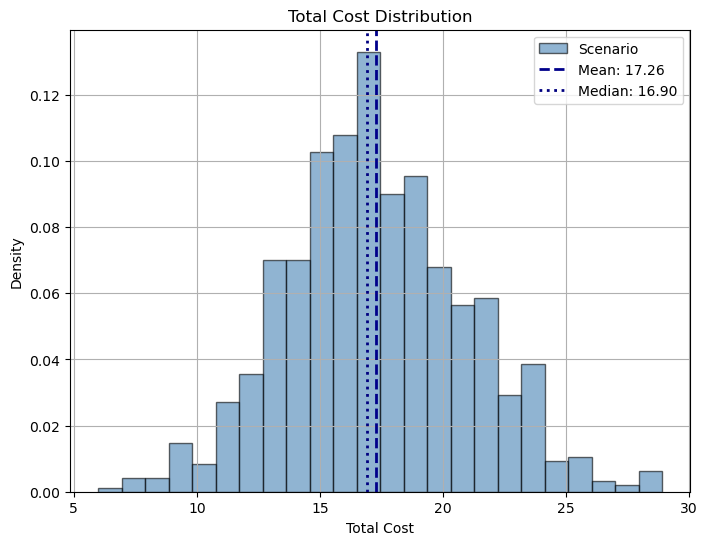

In [12]:
visualize_single_cost_distribution(total_costs)